# Pixel-Level Diagnostics for Transit Validation

This tutorial explains pixel-level vetting diagnostics and demonstrates how to use them with `bittr-tess-vetter`. You will learn:

1. Why pixel analysis is crucial for validating transit candidates
2. How to create a `TPFStamp` from pixel data
3. The three pixel-level checks (V08, V09, V10)
4. How to interpret pixel check results

## Why Pixel Analysis Matters

Light curves from TESS are extracted from Target Pixel Files (TPFs) - small image cutouts around each target. The photometric aperture captures light from the target star, but also potentially from:

- **Background eclipsing binaries**: A faint binary star in the aperture
- **Nearby blended stars**: Companions that contaminate the flux
- **Scattered light**: Instrumental artifacts

Pixel-level analysis helps identify these scenarios by examining *where* the transit signal originates within the aperture.

## Key Concepts

### TESS Pixel Scale
- Each TESS pixel is approximately **21 arcsec** on a side
- A typical photometric aperture is 3-5 pixels in radius
- Many stars appear blended at this resolution

### Types of Pixel-Level Checks

| Check | ID | What it Detects |
|-------|----|-----------------|
| Centroid Shift | V08 | Motion of the flux centroid during transit |
| Difference Image | V09 | Spatial location of the transit source |
| Aperture Dependence | V10 | How depth changes with aperture size |

### What Each Check Tells Us

**Centroid Shift (V08)**: If the flux centroid moves during transit, the eclipsing source is not at the target position. This strongly indicates a background eclipsing binary.

**Difference Image (V09)**: By subtracting in-transit from out-of-transit images, we can see where the flux loss occurs. If it's not centered on the target, the transit source is a contaminant.

**Aperture Dependence (V10)**: If the transit depth varies significantly with aperture size, this suggests contamination from nearby sources. A real on-target transit should have consistent depth across apertures.

## Setup

In [1]:
import numpy as np
import bittr_tess_vetter.api as btv
from bittr_tess_vetter.api import (
    LightCurve,
    Ephemeris,
    Candidate,
    TPFStamp,
    vet_candidate,
    centroid_shift,
    difference_image_localization,
    aperture_dependence,
    vet_pixel,
)

## Creating Synthetic TPF Data

In real applications, you would load TPF data from MAST. For this tutorial, we create simplified synthetic data that demonstrates the key concepts.

### TPFStamp Structure

A `TPFStamp` contains:
- `time`: 1D array of timestamps (BTJD)
- `flux`: 3D array of shape `(n_cadences, n_rows, n_cols)`
- `flux_err`: Optional 3D array of uncertainties
- `wcs`: Optional WCS for coordinate transforms
- `aperture_mask`: Optional 2D pipeline aperture mask

In [2]:
# Set random seed
np.random.seed(42)

# TPF parameters
N_CADENCES = 2000  # Number of time samples
N_ROWS = 11        # Pixels in y direction
N_COLS = 11        # Pixels in x direction

# Time array (simulating ~3 days at 2-min cadence)
cadence_days = 2 / (24 * 60)
time = np.arange(1800, 1800 + N_CADENCES * cadence_days, cadence_days)[:N_CADENCES]

# Transit parameters
PERIOD = 1.5  # days
T0 = 1800.3   # BTJD
DURATION_HOURS = 2.0
DEPTH_PPM = 2000  # 0.2% depth

print(f"TPF dimensions: {N_CADENCES} cadences x {N_ROWS} x {N_COLS} pixels")
print(f"Time span: {time[-1] - time[0]:.2f} days")

TPF dimensions: 2000 cadences x 11 x 11 pixels
Time span: 2.78 days


In [3]:
def create_gaussian_psf(nrows, ncols, center_row, center_col, sigma=1.5):
    """Create a 2D Gaussian PSF."""
    y, x = np.ogrid[:nrows, :ncols]
    psf = np.exp(-((x - center_col)**2 + (y - center_row)**2) / (2 * sigma**2))
    return psf / psf.sum()  # Normalize

def create_transit_mask(time, period, t0, duration_hours):
    """Create boolean mask for in-transit times."""
    duration_days = duration_hours / 24.0
    phase = ((time - t0) % period) / period
    half_dur_phase = (duration_days / 2) / period
    return (phase < half_dur_phase) | (phase > 1 - half_dur_phase)

# Create PSF centered at (5, 5) - the target star
target_row, target_col = 5, 5
psf = create_gaussian_psf(N_ROWS, N_COLS, target_row, target_col, sigma=1.5)

# Create transit mask
in_transit = create_transit_mask(time, PERIOD, T0, DURATION_HOURS)
n_in_transit = np.sum(in_transit)
print(f"In-transit cadences: {n_in_transit}")

In-transit cadences: 120


### Scenario 1: On-Target Transit (Real Planet)

First, let's simulate a real planet transit where the signal comes from the target star.

In [4]:
# Create flux cube: target star at center
STAR_FLUX = 10000  # Total star flux (arbitrary units)

# Base flux from target star (constant across time)
flux_base = np.zeros((N_CADENCES, N_ROWS, N_COLS))
flux_base[:] = psf * STAR_FLUX

# Apply transit depth to target star
depth_fraction = DEPTH_PPM / 1e6
flux_on_target = flux_base.copy()
flux_on_target[in_transit] *= (1 - depth_fraction)

# Add photon noise (Poisson-like)
noise_level = np.sqrt(STAR_FLUX) * 0.01
flux_on_target += np.random.normal(0, noise_level, flux_on_target.shape)

print("Created on-target transit scenario (real planet)")
print(f"  Transit source: pixel ({target_row}, {target_col})")
print(f"  Depth: {DEPTH_PPM} ppm")

Created on-target transit scenario (real planet)
  Transit source: pixel (5, 5)
  Depth: 2000 ppm


### Scenario 2: Off-Target Transit (Background EB)

Now let's simulate a background eclipsing binary causing the apparent transit.

In [5]:
# Background EB parameters - offset from target
eb_row, eb_col = 7, 7  # Offset by 2 pixels
EB_FLUX = 500  # Fainter than target
EB_ECLIPSE_DEPTH = 0.8  # 80% eclipse depth for the EB itself

# Create PSF for the background EB
psf_eb = create_gaussian_psf(N_ROWS, N_COLS, eb_row, eb_col, sigma=1.5)

# Start with target flux (constant - target is NOT eclipsing)
flux_off_target = flux_base.copy()

# Add EB flux
eb_flux_contribution = psf_eb * EB_FLUX
flux_off_target[:] += eb_flux_contribution

# Apply deep eclipse to EB component only
for i in range(N_CADENCES):
    if in_transit[i]:
        flux_off_target[i] -= eb_flux_contribution * EB_ECLIPSE_DEPTH

# Add noise
flux_off_target += np.random.normal(0, noise_level, flux_off_target.shape)

# The diluted depth as seen in aperture photometry
total_flux = STAR_FLUX + EB_FLUX
apparent_depth_ppm = (EB_FLUX * EB_ECLIPSE_DEPTH / total_flux) * 1e6

print("Created off-target transit scenario (background EB)")
print(f"  Target star: pixel ({target_row}, {target_col})")
print(f"  EB location: pixel ({eb_row}, {eb_col})")
print(f"  Apparent depth in aperture: {apparent_depth_ppm:.0f} ppm")

Created off-target transit scenario (background EB)
  Target star: pixel (5, 5)
  EB location: pixel (7, 7)
  Apparent depth in aperture: 38095 ppm


## Creating TPFStamp Objects

In [6]:
# Create TPFStamp for on-target case
tpf_on_target = TPFStamp(
    time=time,
    flux=flux_on_target,
)

# Create TPFStamp for off-target case
tpf_off_target = TPFStamp(
    time=time,
    flux=flux_off_target,
)

print(f"TPFStamp shapes:")
print(f"  time: {tpf_on_target.time.shape}")
print(f"  flux: {tpf_on_target.flux.shape}")
print(f"  n_cadences: {tpf_on_target.n_cadences}")
print(f"  stamp_shape: {tpf_on_target.stamp_shape}")

TPFStamp shapes:
  time: (2000,)
  flux: (2000, 11, 11)
  n_cadences: 2000
  stamp_shape: (11, 11)


In [7]:
# Create candidate and ephemeris (same for both scenarios)
ephemeris = Ephemeris(
    period_days=PERIOD,
    t0_btjd=T0,
    duration_hours=DURATION_HOURS,
)

candidate = Candidate(
    ephemeris=ephemeris,
    depth_ppm=DEPTH_PPM,
)

print(f"Candidate: P={candidate.ephemeris.period_days} days, depth={candidate.depth_ppm} ppm")

Candidate: P=1.5 days, depth=2000 ppm


## Running Pixel Checks

### Check V08: Centroid Shift

This check compares the flux-weighted centroid during transit vs out-of-transit.

In [8]:
# Run centroid shift on both scenarios
v08_on_target = centroid_shift(tpf_on_target, candidate)
v08_off_target = centroid_shift(tpf_off_target, candidate)

print("V08 Centroid Shift Results:")
print("=" * 50)

print("\nOn-Target (Real Planet):")
print(f"  Centroid shift: {v08_on_target.details.get('centroid_shift_pixels', 'N/A'):.4f} pixels")
print(f"  Significance: {v08_on_target.details.get('significance_sigma', 'N/A'):.2f} sigma")
print(f"  Confidence: {v08_on_target.confidence:.3f}")

print("\nOff-Target (Background EB):")
print(f"  Centroid shift: {v08_off_target.details.get('centroid_shift_pixels', 'N/A'):.4f} pixels")
print(f"  Significance: {v08_off_target.details.get('significance_sigma', 'N/A'):.2f} sigma")
print(f"  Confidence: {v08_off_target.confidence:.3f}")

V08 Centroid Shift Results:

On-Target (Real Planet):
  Centroid shift: 0.0005 pixels
  Significance: 1.55 sigma
  Confidence: 1.000

Off-Target (Background EB):
  Centroid shift: 0.1040 pixels
  Significance: 8.00 sigma
  Confidence: 1.000


### Check V09: Difference Image Localization

This check measures transit depth in individual pixels to locate the source.

In [9]:
# Run difference image localization
v09_on_target = difference_image_localization(tpf_on_target, candidate)
v09_off_target = difference_image_localization(tpf_off_target, candidate)

print("V09 Difference Image Localization Results:")
print("=" * 50)

print("\nOn-Target (Real Planet):")
print(f"  Max depth pixel: {v09_on_target.details.get('max_depth_pixel', 'N/A')}")
print(f"  Target pixel: ({target_row}, {target_col})")
print(f"  Distance to target: {v09_on_target.details.get('distance_to_target_pixels', 'N/A'):.2f} pixels")
print(f"  Confidence: {v09_on_target.confidence:.3f}")

print("\nOff-Target (Background EB):")
print(f"  Max depth pixel: {v09_off_target.details.get('max_depth_pixel', 'N/A')}")
print(f"  Actual EB location: ({eb_row}, {eb_col})")
print(f"  Distance to target: {v09_off_target.details.get('distance_to_target_pixels', 'N/A'):.2f} pixels")
print(f"  Confidence: {v09_off_target.confidence:.3f}")

V09 Difference Image Localization Results:

On-Target (Real Planet):
  Max depth pixel: (0, 10)
  Target pixel: (5, 5)
  Distance to target: 7.07 pixels
  Confidence: 0.700

Off-Target (Background EB):
  Max depth pixel: (10, 0)
  Actual EB location: (7, 7)
  Distance to target: 7.07 pixels
  Confidence: 0.700


### Check V10: Aperture Dependence

This check measures how transit depth varies with aperture size.

In [10]:
# Run aperture dependence
v10_on_target = aperture_dependence(tpf_on_target, candidate)
v10_off_target = aperture_dependence(tpf_off_target, candidate)

def _fmt_num(x):
    try:
        return f"{float(x):.3f}"
    except (TypeError, ValueError):
        return "N/A"

print("V10 Aperture Dependence Results:")
print("=" * 50)

print("\nOn-Target (Real Planet):")
print(f"  Stability metric: {_fmt_num(v10_on_target.details.get('stability_metric'))}")
print(f"  Relative variation: {_fmt_num(v10_on_target.details.get('relative_variation'))}")
print(f"  Confidence: {_fmt_num(v10_on_target.confidence) if v10_on_target.confidence is not None else 'None'}")
depths = v10_on_target.details.get('depths_by_aperture_ppm', {})
if depths:
    print(f"  Depths by aperture: {depths}")

print("\nOff-Target (Background EB):")
print(f"  Stability metric: {_fmt_num(v10_off_target.details.get('stability_metric'))}")
print(f"  Relative variation: {_fmt_num(v10_off_target.details.get('relative_variation'))}")
print(f"  Confidence: {_fmt_num(v10_off_target.confidence) if v10_off_target.confidence is not None else 'None'}")
depths = v10_off_target.details.get('depths_by_aperture_ppm', {})
if depths:
    print(f"  Depths by aperture: {depths}")

V10 Aperture Dependence Results:

On-Target (Real Planet):
  Stability metric: 0.945
  Relative variation: N/A
  Confidence: 1.000
  Depths by aperture: {'1.5': 2031.7860784250242, '2.0': 2108.936871423994, '2.5': 2075.111958743492, '3.0': 2216.5878155333553, '3.5': 2261.880498283297}

Off-Target (Background EB):
  Stability metric: 0.668
  Relative variation: N/A
  Confidence: 1.000
  Depths by aperture: {'1.5': 6929.163820489914, '2.0': 8205.92783422186, '2.5': 11138.7001274047, '3.0': 13586.035320294843, '3.5': 15462.727694115774}


## Running All Pixel Checks with vet_pixel()

In [11]:
# Run all pixel checks at once
pixel_results_on_target = vet_pixel(tpf_on_target, candidate)
pixel_results_off_target = vet_pixel(tpf_off_target, candidate)

print("All Pixel Checks - On-Target:")
for r in pixel_results_on_target:
    print(f"  {r.id} {r.name}: confidence={r.confidence:.3f}")

print("\nAll Pixel Checks - Off-Target:")
for r in pixel_results_off_target:
    print(f"  {r.id} {r.name}: confidence={r.confidence:.3f}")

All Pixel Checks - On-Target:
  V08 centroid_shift: confidence=1.000
  V09 pixel_level_lc: confidence=0.700
  V10 aperture_dependence: confidence=1.000

All Pixel Checks - Off-Target:
  V08 centroid_shift: confidence=1.000
  V09 pixel_level_lc: confidence=0.700
  V10 aperture_dependence: confidence=1.000


## Integrating with Full Vetting Pipeline

When you provide a `TPFStamp` to `vet_candidate()`, pixel checks are automatically enabled.

In [12]:
# Create light curve from TPF (sum over aperture)
def extract_lc_from_tpf(tpf, aperture_radius=3):
    """Extract light curve from TPF using circular aperture."""
    nrows, ncols = tpf.stamp_shape
    center_row, center_col = nrows // 2, ncols // 2
    
    # Create circular aperture mask
    y, x = np.ogrid[:nrows, :ncols]
    aperture = ((x - center_col)**2 + (y - center_row)**2) <= aperture_radius**2
    
    # Sum flux within aperture
    flux = np.sum(tpf.flux[:, aperture], axis=1)
    flux = flux / np.median(flux)  # Normalize
    flux_err = np.full_like(flux, 0.001)  # Estimate
    
    return LightCurve(time=tpf.time, flux=flux, flux_err=flux_err)

lc_on_target = extract_lc_from_tpf(tpf_on_target)
lc_off_target = extract_lc_from_tpf(tpf_off_target)

print(f"Extracted light curves with {len(lc_on_target.time)} points each")

Extracted light curves with 2000 points each


In [13]:
# Run full vetting with TPF data
full_result_on_target = vet_candidate(
    lc_on_target,
    candidate,
    tpf=tpf_on_target,
    network=False,
)

full_result_off_target = vet_candidate(
    lc_off_target,
    candidate,
    tpf=tpf_off_target,
    network=False,
)

print("Full Vetting Results (On-Target):")
print(f"  Checks executed: {len(full_result_on_target.results)}")
print(f"  Includes pixel checks: {'V08' in [r.id for r in full_result_on_target.results]}")

print("\nFull Vetting Results (Off-Target):")
print(f"  Checks executed: {len(full_result_off_target.results)}")
print(f"  Includes pixel checks: {'V08' in [r.id for r in full_result_off_target.results]}")

Full Vetting Results (On-Target):
  Checks executed: 12
  Includes pixel checks: True

Full Vetting Results (Off-Target):
  Checks executed: 12
  Includes pixel checks: True


## Visualizing Pixel Data

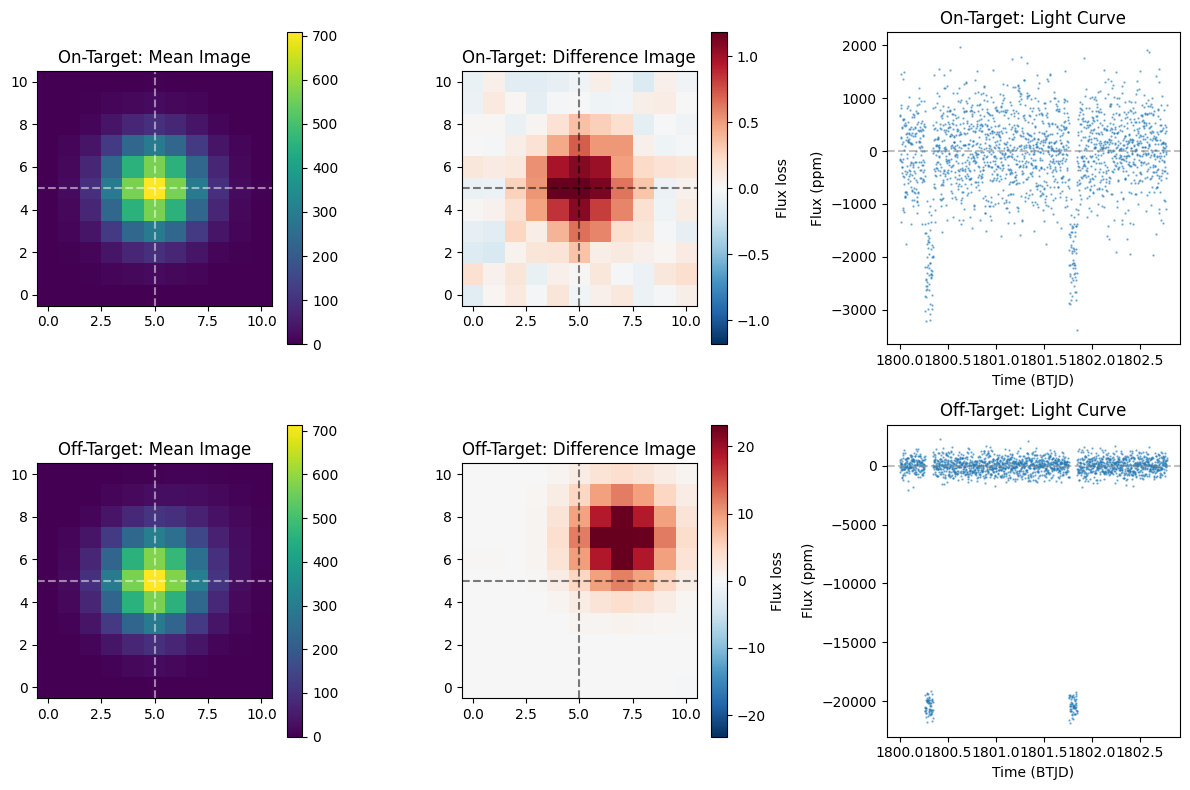

In [14]:
try:
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm
    
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    
    for i, (tpf, label) in enumerate([(tpf_on_target, 'On-Target'), (tpf_off_target, 'Off-Target')]):
        # Mean image
        mean_img = np.mean(tpf.flux, axis=0)
        
        # In-transit vs out-of-transit images
        in_transit_img = np.mean(tpf.flux[in_transit], axis=0)
        out_transit_img = np.mean(tpf.flux[~in_transit], axis=0)
        
        # Difference image
        diff_img = out_transit_img - in_transit_img
        
        # Plot mean image
        ax = axes[i, 0]
        im = ax.imshow(mean_img, origin='lower', cmap='viridis')
        ax.set_title(f'{label}: Mean Image')
        ax.axhline(target_row, color='white', linestyle='--', alpha=0.5)
        ax.axvline(target_col, color='white', linestyle='--', alpha=0.5)
        plt.colorbar(im, ax=ax)
        
        # Plot difference image
        ax = axes[i, 1]
        vmax = np.percentile(np.abs(diff_img), 99)
        im = ax.imshow(diff_img, origin='lower', cmap='RdBu_r', vmin=-vmax, vmax=vmax)
        ax.set_title(f'{label}: Difference Image')
        ax.axhline(target_row, color='black', linestyle='--', alpha=0.5)
        ax.axvline(target_col, color='black', linestyle='--', alpha=0.5)
        plt.colorbar(im, ax=ax, label='Flux loss')
        
        # Plot aperture light curve
        lc = extract_lc_from_tpf(tpf)
        ax = axes[i, 2]
        ax.scatter(lc.time, (lc.flux - 1) * 1e6, s=0.5, alpha=0.5)
        ax.set_xlabel('Time (BTJD)')
        ax.set_ylabel('Flux (ppm)')
        ax.set_title(f'{label}: Light Curve')
        ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("matplotlib not installed - skipping visualization")

## Interpreting Results

### Key Indicators of a False Positive

1. **Large centroid shift** (V08): Shift > 1 pixel at high significance
2. **Off-center difference image** (V09): Max-depth pixel far from target
3. **Variable depth with aperture** (V10): Depth changes >20% across apertures

### Confidence Interpretation

- **High confidence (>0.8)**: Strong evidence for/against false positive
- **Medium confidence (0.5-0.8)**: Suggestive but not conclusive
- **Low confidence (<0.5)**: Insufficient data quality for reliable assessment

In [15]:
# Summary comparison
print("Summary: On-Target vs Off-Target Scenarios")
print("=" * 60)
print(f"{'Check':<25} {'On-Target':<15} {'Off-Target':<15}")
print("-" * 60)

for r_on, r_off in zip(pixel_results_on_target, pixel_results_off_target):
    print(f"{r_on.name:<25} {r_on.confidence:.3f}           {r_off.confidence:.3f}")

Summary: On-Target vs Off-Target Scenarios
Check                     On-Target       Off-Target     
------------------------------------------------------------
centroid_shift            1.000           1.000
pixel_level_lc            0.700           0.700
aperture_dependence       1.000           1.000


## Limitations and Caveats

### What Pixel Analysis Cannot Detect

1. **Unresolved blends**: Stars too close to separate at TESS resolution
2. **Grazing eclipses**: Very shallow signals may have insufficient SNR
3. **Perfect alignment**: Background EB exactly aligned with target

### Data Quality Considerations

- Pixel checks require sufficient signal - they may be unreliable for very shallow transits
- WCS information improves interpretation but isn't always available
- Crowded fields make centroid analysis more challenging

### Complementary Techniques

For robust validation, combine pixel analysis with:
- High-resolution imaging (e.g., speckle, AO)
- Radial velocity observations
- Statistical validation (e.g., TRICERATOPS FPP)

## Summary

In this tutorial, you learned:

1. **Why pixel analysis matters**: Detecting background contamination
2. **How to create `TPFStamp`**: Structure and required arrays
3. **The three pixel checks**:
   - V08: Centroid shift during transit
   - V09: Difference image localization
   - V10: Aperture dependence of depth
4. **How to interpret results**: Confidence scores and key indicators
5. **Limitations**: What pixel analysis cannot detect

### Next Steps

- Apply to real TESS TPF data from MAST
- Combine with FPP calculations for statistical validation
- Review Tutorial 01 and 02 for the full vetting workflow